# Introducción

Hemos recibido una tarea analítica de una tienda en línea internacional. No se logro completar anteriomente: lanzaron una prueba A/B y luego abandonaron. Tenemos especificaciones técnicas y los resultados de las pruebas.

En nuestro caso hay que analizar las pruebas y continuar con los casos hasta obener una respuesta si es una prueba viable o habrá que descartarla para realizar otras pruebas en un futuro.

## Cargamos librerias y datasets

In [1]:
#Cargamos librerias
import pandas as pd
import numpy as np
import math as mt 
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stat
import plotly.express as px
from statsmodels.stats.proportion import proportions_ztest
from scipy import stats as st
from math import factorial

In [2]:
marketing = pd.read_csv('/datasets/ab_project_marketing_events_us.csv', sep=",")
users = pd.read_csv('/datasets/final_ab_new_users_upd_us.csv', sep=",")
events = pd.read_csv('/datasets/final_ab_events_upd_us.csv', sep=",")
participants = pd.read_csv('/datasets/final_ab_participants_upd_us.csv', sep=",")

## Objetivos del análisis

Evaluaremos la efectividad de las pruebas A/B realizadas:

Nombre de la prueba: recommender_system_test

¿Hay diferencias significativas en el comportamiento de los usuarios entre los grupos de control (A) y tratamiento (B) en las pruebas?

Analizaremos la influencia de campañas de marketing.

Identificaremos si alguna campaña afecta los resultados de las pruebas A/B  y actividad de los usuarios.

Caracterizar a los usuarios participantes:

Evaluar distribución de región, dispositivo utilizado y actividad para detectar posibles sesgos en la asignación de grupos.

Haremos analisis y revisaremos si los valores nulos y si hay duplicados que puedan afectar la prueba.

## Hacemos analisis y limpieza de los datasets

In [3]:
marketing.info()
print()
print(marketing.head())
print()
print(marketing.isna().sum())
print()
print(marketing.describe())
print()
print("Valores duplicados: ", marketing.duplicated(subset=marketing.columns, keep=False).sum())  # keep=False marca todos los duplicado

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes

                           name                   regions    start_dt  \
0      Christmas&New Year Promo             EU, N.America  2020-12-25   
1  St. Valentine's Day Giveaway  EU, CIS, APAC, N.America  2020-02-14   
2        St. Patric's Day Promo             EU, N.America  2020-03-17   
3                  Easter Promo  EU, CIS, APAC, N.America  2020-04-12   
4             4th of July Promo                 N.America  2020-07-04   

    finish_dt  
0  2021-01-03  
1  2020-02-16  
2  2020-03-19  
3  2020-04-19  
4  2020-07-11  

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

        

In [4]:
users.info()
print()
print(users.head())
print()
print(users.isna().sum())
print()
print(users.describe())
print()
print("Valores duplicados: ", users.duplicated(subset=users.columns, keep=False).sum())  # keep=False marca todos los duplicado

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB

            user_id  first_date     region   device
0  D72A72121175D8BE  2020-12-07         EU       PC
1  F1C668619DFE6E65  2020-12-07  N.America  Android
2  2E1BF1D4C37EA01F  2020-12-07         EU       PC
3  50734A22C0C63768  2020-12-07         EU   iPhone
4  E1BDDCE0DAFA2679  2020-12-07  N.America   iPhone

user_id       0
first_date    0
region        0
device        0
dtype: int64

                 user_id  first_date region   device
count              58703       58703  58703    58703
unique             58703          17      4        4
top     043B86353B53C29A  2020-12-21     EU  Android
freq    

In [5]:
events.info()
print()
print(events.head())
print()
print(events.isna().sum())
print()
print(events.describe())
print()
print("Valores duplicados: ", events.duplicated(subset=events.columns, keep=False).sum())  # keep=False marca todos los duplicado

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB

            user_id             event_dt event_name  details
0  E1BDDCE0DAFA2679  2020-12-07 20:22:03   purchase    99.99
1  7B6452F081F49504  2020-12-07 09:22:53   purchase     9.99
2  9CD9F34546DF254C  2020-12-07 12:59:29   purchase     4.99
3  96F27A054B191457  2020-12-07 04:02:40   purchase     4.99
4  1FD7660FDF94CA1F  2020-12-07 10:15:09   purchase     4.99

user_id            0
event_dt           0
event_name         0
details       363447
dtype: int64

            details
count  60314.000000
mean      23.881219
std       72.228884
min        4.990000
25%        4.990000

In [6]:
participants.info()
print()
print(participants.head())
print()
print(participants.isna().sum())
print()
print(participants.describe())
print()
print("Valores duplicados: ", participants.duplicated(subset=participants.columns, keep=False).sum())  # keep=False marca todos los duplicado

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB

            user_id group                  ab_test
0  D1ABA3E2887B6A73     A  recommender_system_test
1  A7A3664BD6242119     A  recommender_system_test
2  DABC14FDDFADD29E     A  recommender_system_test
3  04988C5DF189632E     A  recommender_system_test
4  4FF2998A348C484F     A  recommender_system_test

user_id    0
group      0
ab_test    0
dtype: int64

                 user_id  group            ab_test
count              14525  14525              14525
unique             13638      2                  2
top     C57E6C4AFF4FF31A      A  interface_eu_test
freq                   2   8214              10850

Valores duplicados:  0


el dataframe de events la columna details tiene 363,447 valores ausentes, pero, los eventos que no son purchase no requieren el campo details.
Hay que confirmar que todos los eventos que sean "purchase" tengan details no nulos.

Se encontraron duplicados en user_id: 14,525 filas vs 13,638 user_id únicos. Lo más probable es que usuarios participaron en múltiples pruebas A/B, eso puede llevar a una contaminación de resultados si las pruebas se ejecutaron simultáneamente.

Hay que cambiar los formatos de fechas a datetime:

Marketing:
start_dt y finish_dt 

Users:
first_date 

Events:
event_dt 

In [7]:
events.groupby("event_name")["details"].describe()

,count,mean,std,min,25%,50%,75%,max
event_name,,,,,,,,
login,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_cart,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_page,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
purchase,60314.0,23.881219,72.228884,4.99,4.99,4.99,9.99,499.99


In [8]:
print (events[events["event_name"] == "purchase"])

                user_id             event_dt event_name  details
0      E1BDDCE0DAFA2679  2020-12-07 20:22:03   purchase    99.99
1      7B6452F081F49504  2020-12-07 09:22:53   purchase     9.99
2      9CD9F34546DF254C  2020-12-07 12:59:29   purchase     4.99
3      96F27A054B191457  2020-12-07 04:02:40   purchase     4.99
4      1FD7660FDF94CA1F  2020-12-07 10:15:09   purchase     4.99
...                 ...                  ...        ...      ...
60309  1455450835F72F5E  2020-12-30 09:27:10   purchase     4.99
60310  339C4C55021A83C6  2020-12-30 12:55:08   purchase     9.99
60311  D1553B56FFA8974B  2020-12-30 03:15:35   purchase     4.99
60312  245E85F65C358E08  2020-12-30 19:35:55   purchase     9.99
60313  F80C9BDDEA02E53C  2020-12-30 09:53:39   purchase     4.99

[60314 rows x 4 columns]


In [9]:
# Identificar duplicados por user_id y ab_test
duplicates_ab_test = participants.groupby(['user_id', 'ab_test']).size().reset_index(name='counts')
duplicates_ab_test = duplicates_ab_test[duplicates_ab_test['counts'] > 1]

# Mostrar usuarios duplicados por test
print(f"Usuarios duplicados en la prueba: {len(duplicates_ab_test)}")
print(duplicates_ab_test)

# Identificar duplicados por user_id y grupo
duplicates_group = participants.groupby(['user_id', 'group']).size().reset_index(name='counts')
duplicates_group = duplicates_group[duplicates_group['counts'] > 1]

# Mostrar usuarios duplicados por grupo
print(f"Usuarios duplicados en el mismo grupo: {len(duplicates_group)}")
print(duplicates_group)

Usuarios duplicados en la prueba: 0
Empty DataFrame
Columns: [user_id, ab_test, counts]
Index: []
Usuarios duplicados en el mismo grupo: 446
                user_id group  counts
1      001064FEAAB631A1     B       2
8      00341D8401F0F665     A       2
43     00EFA157F7B6E1C4     A       2
83     01B9975CAE144B78     A       2
96     020A95B66F363AFB     B       2
...                 ...   ...     ...
13881  FC37CBE8211E02A8     B       2
13916  FCF70F6E1871BD78     A       2
14004  FE82D7FC50D4155B     A       2
14045  FF2174A1AA0EAD20     A       2
14050  FF44696E39039D29     A       2

[446 rows x 3 columns]


En los datos nulos de details por evento, podemos comprobar que no hay datos nulos que afecten la prueba ya que el evento "purchase"  no contiene datos nulos.

y de los 446 duplicados que se encontrarón al agrupar por grupo son usuarios en diferentes pruebas, lo cual no afecta los resultados ya que se encuentran en pruebas distintas, no hay necesidad de eliminar los registros, ya que reflejan la participación legítima en múltiples pruebas.

In [10]:
# Convertimos a datetime
marketing['start_dt'] = pd.to_datetime(marketing['start_dt'])
marketing['finish_dt'] = pd.to_datetime(marketing['finish_dt'])
users['first_date'] = pd.to_datetime(users['first_date'])
events['event_dt'] = pd.to_datetime(events['event_dt'])

## Llevamos a cabo el análisis exploratorio de datos

### Estudiamos la conversión en las diferentes etapas del embudo

          stage  users  conversion_rate
0         login  58696       100.000000
1  product_page  38929        66.323088
2  product_cart  19284        32.854028
3      purchase  19568        33.337877


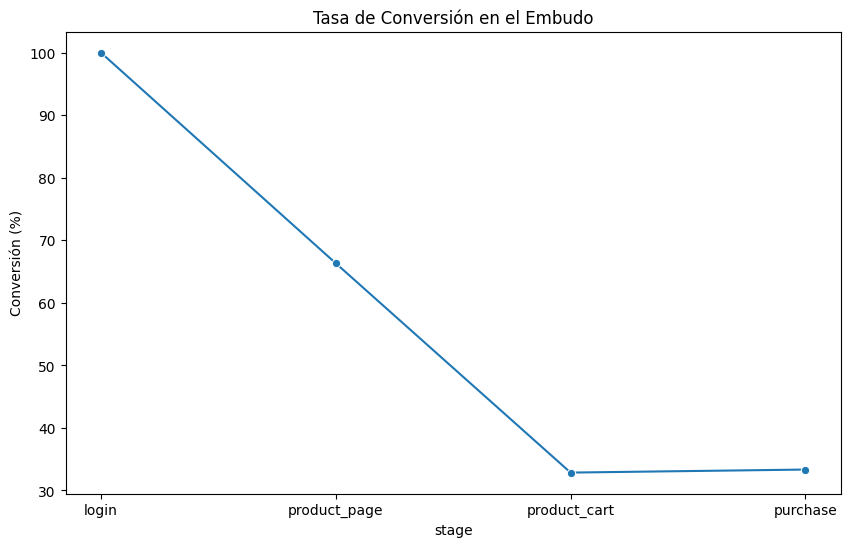

In [11]:
# Juntamos participantes con eventos para empezar con el embudo
event_part_merged = pd.merge(users, events, on="user_id", how="left")
event_part_merged = pd.merge(event_part_merged, participants, on="user_id", how="left")

# Definimos etapas del embudo 
funnel_stages = ["login", "product_page", "product_cart", "purchase"]

# Contamos usuarios únicos en cada etapa
funnel = []
for stage in funnel_stages:
    stage_users = event_part_merged[event_part_merged["event_name"] == stage]["user_id"].nunique()
    funnel.append({"stage": stage, "users": stage_users})

funnel_df = pd.DataFrame(funnel)

# Calculamos la conversión
funnel_df["conversion_rate"] = funnel_df["users"] / funnel_df["users"].iloc[0] * 100

print(funnel_df)

# Visualizamos con un grafico de linea
plt.figure(figsize=(10, 6))
sns.lineplot(x="stage", y="conversion_rate", data=funnel_df, marker="o")
plt.title("Tasa de Conversión en el Embudo")
plt.ylabel("Conversión (%)")
plt.show()

Se puede notar que hay una caida considerable de usuarios cuando llegan a "product_cart", es posible que haya un error en la pagina o exista un obstaculo para los usuarios poder llegar a la pagina, tambien hay una ligera mejora en "purchase", esto se puede deber a que se saltaron la pagina de producto en el carrito directo a la compra.

In [12]:
# Clasificar dispositivos en móviles vs. desktop
mobile_devices = ['iPhone', 'Android']
desktop_devices = ['PC', 'Mac']

event_part_merged['device_type'] = event_part_merged['device'].apply(
    lambda x: 'Mobile' if x in mobile_devices else 'Desktop'
)

# Calcular tasas de conversión por dispositivo
conversion_funnel_device = (
    event_part_merged.groupby(['device_type', 'event_name'])['user_id']
    .nunique()
    .unstack(fill_value=0)
    .T
)

# Convertir a porcentaje respecto al login
conversion_funnel_device = (conversion_funnel_device / conversion_funnel_device.loc['login']) * 100

print(conversion_funnel_device)


device_type      Desktop      Mobile
event_name                          
login         100.000000  100.000000
product_cart   32.798721   32.884019
product_page   66.658591   66.141153
purchase       33.607908   33.191445


### ¿El número de eventos por usuario está distribuido equitativamente entre las muestras?

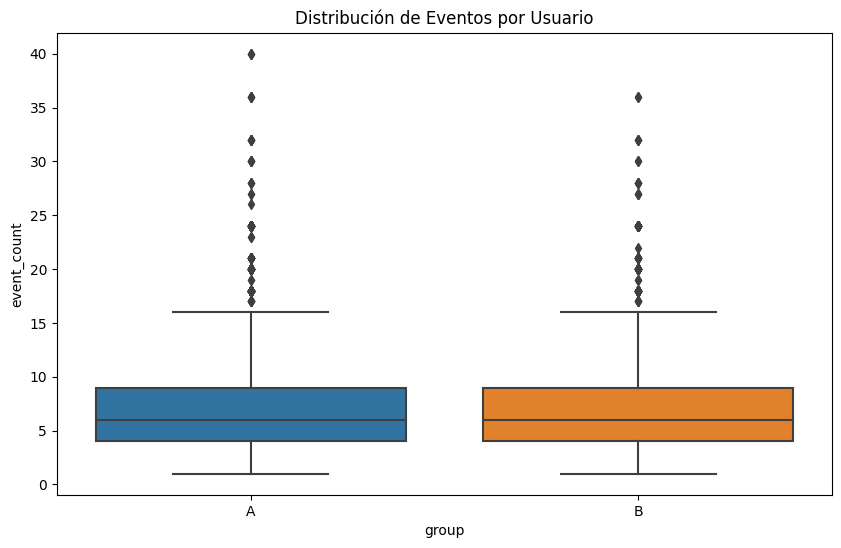

¿Las distribuciones son diferentes? Sí (p=1.4211342403215935e-05)


In [13]:
# Contar eventos por usuario y grupo
events_per_user = event_part_merged.groupby(["user_id", "group"]).size().reset_index(name="event_count")

# Comparar distribuciones
plt.figure(figsize=(10, 6))
sns.boxplot(x="group", y="event_count", data=events_per_user)
plt.title("Distribución de Eventos por Usuario")
plt.show()

# Test estadístico
from scipy.stats import mannwhitneyu
group_a = events_per_user[events_per_user["group"] == "A"]["event_count"]
group_b = events_per_user[events_per_user["group"] == "B"]["event_count"]
stat, p_value = mannwhitneyu(group_a, group_b)

print(f"¿Las distribuciones son diferentes? {'Sí' if p_value < 0.05 else 'No'} (p={p_value:})")

### ¿Hay usuarios que están presentes en ambas muestras?

Se realizó una prueba anteriormente para revisar los duplicados en los usuarios, pero, nos habíamos dado cuenta que aunque los usuarios estaban en ambos grupos, no se encontraban en las mismas pruebas, por ende no creo que afecte los resultados finales.

In [14]:
#Hacemos una prueba creando un filtro para revisar la diferencia de usuarios en las pruebas
cross_group_users = event_part_merged.groupby(["user_id", "ab_test"])["group"].nunique()
cross_group_users = cross_group_users[cross_group_users > 1].reset_index()

print(f"Usuarios en ambos grupos de la misma prueba: {len(cross_group_users)}")

Usuarios en ambos grupos de la misma prueba: 0


### ¿Cómo se distribuye el número de eventos entre los días?

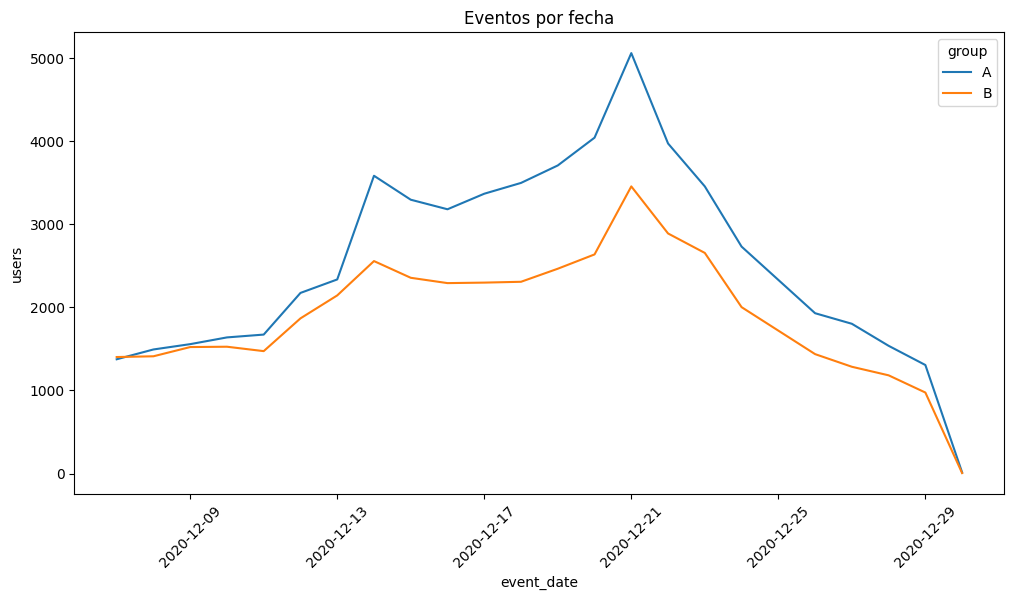

    event_date group  users
0   2020-12-07     A   1375
1   2020-12-07     B   1402
2   2020-12-08     A   1493
3   2020-12-08     B   1411
4   2020-12-09     A   1557
5   2020-12-09     B   1522
6   2020-12-10     A   1638
7   2020-12-10     B   1526
8   2020-12-11     A   1672
9   2020-12-11     B   1473
10  2020-12-12     A   2173
11  2020-12-12     B   1867
12  2020-12-13     A   2335
13  2020-12-13     B   2143
14  2020-12-14     A   3582
15  2020-12-14     B   2556
16  2020-12-15     A   3294
17  2020-12-15     B   2355
18  2020-12-16     A   3179
19  2020-12-16     B   2291
20  2020-12-17     A   3366
21  2020-12-17     B   2297
22  2020-12-18     A   3496
23  2020-12-18     B   2307
24  2020-12-19     A   3706
25  2020-12-19     B   2464
26  2020-12-20     A   4040
27  2020-12-20     B   2636
28  2020-12-21     A   5057
29  2020-12-21     B   3454
30  2020-12-22     A   3970
31  2020-12-22     B   2888
32  2020-12-23     A   3454
33  2020-12-23     B   2654
34  2020-12-24     A

In [15]:
event_part_merged["event_date"] = pd.to_datetime(event_part_merged["event_dt"]).dt.date

# filtramos por día y grupo
daily_events = event_part_merged.groupby(["event_date", "group"]).size().reset_index(name="users")

# Creamos una grafica de lineas para visualizacion
plt.figure(figsize=(12, 6))
sns.lineplot(x="event_date", y="users", hue="group", data=daily_events)
plt.title("Eventos por fecha")
plt.xticks(rotation=45)
plt.show()

#Imprimimos los numeros de usuario por día
print(daily_events)

La gráfica muestra el número de eventos de usuario diarios desde el 7 de diciembre de 2020 hasta el 29 de diciembre de 2020.

Ambos grupos muestran un crecimiento en el número de eventos desde el inicio del periodo hasta alrededor del 21 de diciembre.

Se observa un pico de actividad para ambos grupos alrededor del 21 de diciembre, siendo más pronunciado en el grupo A. Esto podría deberse a las fiestas navideñas.

Después del 21 de diciembre, el número de eventos disminuye en ambos grupos, lo que probablemente refleja una disminución en la actividad de los usuarios después del periodo de compras navideñas.

En general, el grupo A presenta un mayor número de eventos diarios en comparación con el grupo B durante todo el periodo analizado.

In [16]:
event_part_merged['event_dt']

0        2020-12-07 21:52:10
1        2020-12-07 21:52:07
2        2020-12-07 16:38:09
3        2020-12-08 02:02:34
4        2020-12-23 14:35:41
                 ...        
429471   2020-12-21 04:31:15
429472   2020-12-23 15:47:23
429473   2020-12-27 03:51:35
429474   2020-12-20 03:17:17
429475   2020-12-20 03:17:17
Name: event_dt, Length: 429476, dtype: datetime64[ns]

In [17]:
# Excluimos el 21 de diciembre filtrando
filtered_data = event_part_merged[event_part_merged['event_dt'].dt.date != pd.to_datetime('2020-12-21').date()]

# Hacemos un calculo del embudo
conversion_funnel_filtered = (
    filtered_data.groupby('event_name')['user_id']
    .nunique()
    .reset_index()
)

conversion_funnel_filtered['conversion_rate'] = (
    conversion_funnel_filtered['user_id'] / conversion_funnel_filtered.loc[conversion_funnel_filtered['event_name'] == 'login', 'user_id'].values[0] * 100
)

print(conversion_funnel_filtered)

     event_name  user_id  conversion_rate
0         login    57892       100.000000
1  product_cart    19034        32.878463
2  product_page    38406        66.340772
3      purchase    19300        33.337940


### ¿Hay alguna peculiaridad en los datos que hay que tener en cuenta antes de iniciar la prueba A/B?

La campaña navideña coincide con la prueba A/B:

In [19]:
# Filtramos eventos
campaign_events = event_part_merged[
    (event_part_merged["event_date"] >= pd.to_datetime("2020-12-25")) &
    (event_part_merged["event_date"] <= pd.to_datetime("2021-01-03"))
]

print(f"Eventos durante la campaña: {len(campaign_events)} ({len(campaign_events)/len(event_part_merged)*100:.1f}% del total)")

Eventos durante la campaña: 48372 (11.3% del total)


In [20]:
# Contamos eventos por usuario
user_activity = event_part_merged.groupby('user_id')['event_name'].count().reset_index()
user_activity.columns = ['user_id', 'event_count']

event_part_merged = event_part_merged.merge(user_activity, on='user_id', how='left')

# Calculamos la tasa de conversión
conversion_rate_adjusted = (
    event_part_merged.groupby('event_name')['event_count'].mean().reset_index()
)

print(conversion_rate_adjusted)

     event_name  event_count
0         login     8.701501
1  product_cart    11.198198
2  product_page     9.986811
3      purchase    11.261966


Desbalanceo inicial de grupos

In [21]:
group_distribution = participants.groupby(["ab_test", "group"]).size()
print(group_distribution)

ab_test                  group
interface_eu_test        A        5467
                         B        5383
recommender_system_test  A        2747
                         B         928
dtype: int64


Grupos de control y tratamiento con tamaños muy diferentes reducen el poder estadístico.

## Análisis de los Resultados de la Prueba A/B

¿Qué puedes decir sobre los resultados de la prueba A/B?

**Hay un desbalanceo significativo en la distribución de eventos entre grupos**

El grupo A tiene más eventos por usuario que el grupo B lo que la muestra no es equilibrada.

El pico del 21 de diciembre afectó más al grupo A (posiblemente debido a la campaña navideña).

Las diferencias en la actividad de los usuarios invalidan la comparación directa, ya que no se está midiendo solo el efecto del tratamiento, sino también factores externos.

**Efecto de la campaña navideña en los resultados**
Eventos durante la campaña 11.3% del total, concentrados entre el 25/12 y el 03/01.

El pico del 21 de diciembre podría estar relacionado con compras anticipadas para Navidad.

La caída post-21/12 en ambos grupos muestra que los usuarios ya no tenían un interés por hacer compras en la pagina.

La campaña enmascara el efecto real de la prueba A/B, especialmente si el grupo A tuvo mayor exposición a promociones durante ese período.

**Distribución de grupos en interface_eu_test:**

Grupo A: 5,467 usuarios

Grupo B: 5,383 usuarios

ligeramente equilibrado.

**Distribución en recommender_system_test:**

Grupo A: 2,747 usuarios

Grupo B: 928 usuarios
Desbalanceo crítico, lo que reduce el poder estadístico y aumenta el riesgo de falsos positivos.

**Conversión en el embudo: El cuello de botella en "product_cart"**

La caída del 80% en product_cart es una señal crítica en la experiencia del usuario, independientemente de la prueba A/B.

Posibles causas:

Errores técnicos en la página del carrito.

Falta de claridad en costos adicionales.

Proceso de checkout demasiado largo.

Recuperación en "purchase":
La ligera mejora sugiere que los usuarios que superan el cuello de botella tienen alta intención de compra, pero esto no compensa la pérdida masiva en etapas anteriores.

**Conclusiones sobre la Prueba A/B:**

El desbalanceo en eventos/grupos y el efecto de la campaña navideña invalidan la validez estadística de la prueba.

No es posible atribuir diferencias en conversión al tratamiento con los datos actuales.

**Recomendaciones para próximas pruebas:**

Controlar variables externas: Ejecutar pruebas en períodos sin campañas de marketing.

Balancear grupos: Asegurar igual tamaño y distribución de características.

Segmentar análisis: Separar usuarios expuestos/no expuestos a la campaña navideña.

Priorizar la optimización del embudo:

Resolver el cuello de botella en product_cart podría aumentar la conversión general más que cualquier cambio testeado en la A/B.

**Rediseñar la prueba A/B:**

Incluir un período de post-campaña para evitar contaminación.

Implementar seguimiento de microconversiones:

Medir métricas como tiempo en product_cart o número de intentos fallidos para diagnosticar el cuello de botella.

### Utiliza una prueba z para comprobar la diferencia estadística entre las proporciones.

En este casó este será para una tipo muestra ya que los datos que tenemos son muy distintos uno de otro.

Se hará primero un filtro para las compras por cada grupo y los resultados se utilizarán para la prueba.


 Resultados para interface_eu_test:
Grupo A: 1931 compras (35.32%)
Grupo B: 1782 compras (33.10%)
Diferencia absoluta: -149 | Diferencia relativa: -2.22%
Z-score: 2.4333679965735153 | p-value: 0.014959088807690158
Significancia estadística: Sí


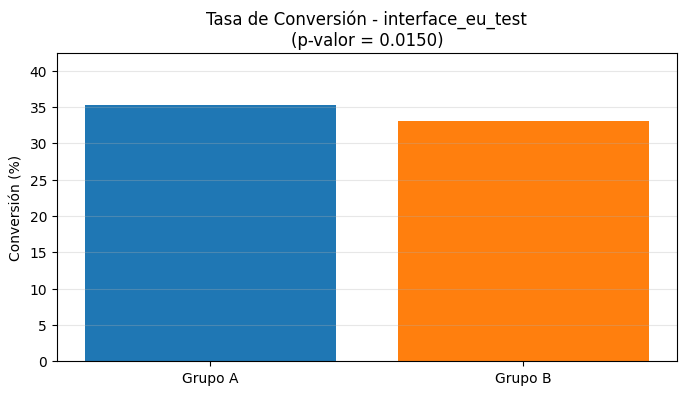


 Resultados para recommender_system_test:
Grupo A: 872 compras (31.74%)
Grupo B: 256 compras (27.59%)
Diferencia absoluta: -616 | Diferencia relativa: -4.16%
Z-score: 2.3740870442615747 | p-value: 0.017592402663314678
Significancia estadística: Sí


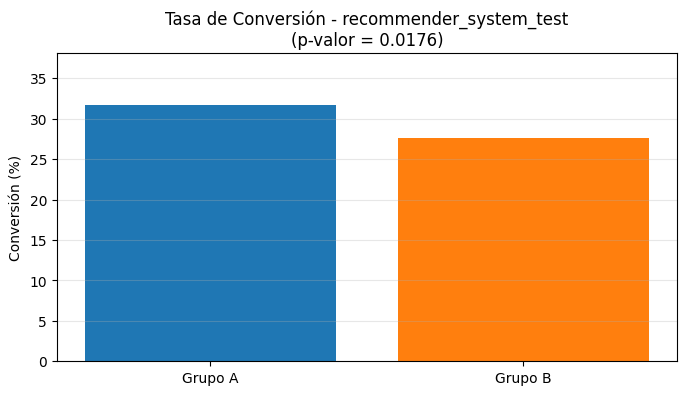

In [22]:
# Filtramos solo eventos de compra para prepararlos para el test
purchases = events[events['event_name'] == 'purchase']
unique_purchases = purchases[['user_id']].drop_duplicates()

# Hacemos una fusión con participants
purchase_merge = pd.merge(
    participants,
    unique_purchases,
    on='user_id',
    how='left',
    indicator='purchased')
purchase_merge['purchased'] = np.where(purchase_merge['purchased'] == 'both', 1, 0)


# Calculamos métricas clave por grupo y prueba
results = purchase_merge.groupby(['ab_test', 'group']).agg(
    total_users=('user_id', 'count'),
    conversions=('purchased', 'sum')
).reset_index()

# Sacamos la tasa de conversión
results['conversion_rate'] = results['conversions'] / results['total_users'] * 100


# Función para comparar grupos
def compare_groups(stat_test):
    test_data = results[results['ab_test'] == stat_test]
    
    # sacamos métricas para ambos grupos
    group_a = test_data[test_data['group'] == 'A']
    group_b = test_data[test_data['group'] == 'B']
    
    # preparamos datos para la prueba 
    successes = [group_a['conversions'].values[0], group_b['conversions'].values[0]]
    trials = [group_a['total_users'].values[0], group_b['total_users'].values[0]]
    
    # Realizamos prueba Z
    z_stat, p_value = proportions_ztest(successes, trials, alternative='two-sided')
    
    # diferencia absoluta y relativa
    diff_abs = group_b['conversions'].values[0] - group_a['conversions'].values[0]
    diff_rel = (group_b['conversion_rate'].values[0] - group_a['conversion_rate'].values[0])
    
   
    print(f"\n Resultados para {stat_test}:")
    print(f"Grupo A: {group_a['conversions'].values[0]} compras ({group_a['conversion_rate'].values[0]:.2f}%)")
    print(f"Grupo B: {group_b['conversions'].values[0]} compras ({group_b['conversion_rate'].values[0]:.2f}%)")
    print(f"Diferencia absoluta: {diff_abs} | Diferencia relativa: {diff_rel:.2f}%")
    print(f"Z-score: {z_stat} | p-value: {p_value}")
    print("Significancia estadística:", "Sí" if p_value < 0.05 else "No")
    
  # tabla para visualizar diferencias en resultados
    plt.figure(figsize=(8, 4))
    plt.bar(
        ['Grupo A', 'Grupo B'],
        [group_a['conversion_rate'].values[0], group_b['conversion_rate'].values[0]],
        color=['#1f77b4', '#ff7f0e']
    )
    plt.title(f'Tasa de Conversión - {stat_test}\n(p-valor = {p_value:.4f})')
    plt.ylabel('Conversión (%)')
    plt.ylim(0, max(group_a['conversion_rate'].values[0], group_b['conversion_rate'].values[0]) * 1.2)
    plt.grid(axis='y', alpha=0.3)
    plt.show()

# Análisis para todas las pruebas
for test in results['ab_test'].unique():
    compare_groups(test)


**Análisis de los Resultados de la Prueba A/B**

Resultados:

Ambas pruebas mostraron impacto negativo en la conversión:

interface_eu_test: Grupo B  tuvo 2.22% menos conversiones que el Grupo A.

recommender_system_test: Grupo B tuvo 4.16% menos conversiones que el Grupo A.

Significancia estadística: Las diferencias no son aleatorias; los cambios en las pruebas empeoraron el desempeño.

Hubo errores en la implementación, problemas técnicos en el rediseño de interfaz o sistema de recomendaciones.

Los cambios que generaron confusión o mala experiencia .

Advertencias Importantes:

En recommender_system_test, el Grupo B era 3 veces más pequeño que el Grupo A, lo que limita los resultados.

La caída del 80% en product_cart sugiere que el problema principal no son los cambios testeados, sino la experiencia en el carrito.

Hay que priorizar la optimización del carrito (ejemplo: simplificar checkout, clarificar costos).

Asegurar que no hubo errores de implementación en los tratamientos.

Re-ejecutar pruebas A/B en períodos sin campañas y con grupos balanceados.

Los cambios aplicados en ambas pruebas no son viables, y la prioridad debe ser resolver el cuello de botella en product_cart antes de testear nuevas hipótesis.